In [15]:
import numpy as np
import torch

from torch import nn
from torch.nn import functional as F
from PIL import Image
from torchvision import transforms, datasets, models
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [16]:
class MyOwnCifar(torch.utils.data.Dataset):

    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]

In [17]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.dp_one = nn.Dropout(0.2)
        self.dp_two = nn.Dropout(0.2)

        self.bn_one = torch.nn.BatchNorm2d(3)
        self.conv_one = torch.nn.Conv2d(3, 60, 3)
        self.bn_two = torch.nn.BatchNorm2d(60)
        self.conv_two = torch.nn.Conv2d(60, 120, 3)
        self.bn_three = torch.nn.BatchNorm2d(120)
        self.conv_three = torch.nn.Conv2d(120, 240, 3)
        self.bn_four = torch.nn.BatchNorm2d(240)
        self.fc1 = torch.nn.Linear(960, 480)
        self.fc2 = torch.nn.Linear(480, 240)
        self.out = torch.nn.Linear(240, 100)

    def forward(self, x):
        x = self.bn_one(x)
        x = self.conv_one(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.bn_two(x)
        x = self.conv_two(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.bn_three(x)
        x = self.conv_three(x)
        x = F.leaky_relu(x, 0.1)
        x = F.max_pool2d(x, 2)

        x = self.bn_four(x)
        x = x.view(x.size(0), -1)
        x = self.dp_one(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp_two(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.out(x)

net = Net().to(device)
print(net)

Net(
  (dp_one): Dropout(p=0.2, inplace=False)
  (dp_two): Dropout(p=0.2, inplace=False)
  (bn_one): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_one): Conv2d(3, 60, kernel_size=(3, 3), stride=(1, 1))
  (bn_two): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_two): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1))
  (bn_three): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_three): Conv2d(120, 240, kernel_size=(3, 3), stride=(1, 1))
  (bn_four): BatchNorm2d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=960, out_features=480, bias=True)
  (fc2): Linear(in_features=480, out_features=240, bias=True)
  (out): Linear(in_features=240, out_features=100, bias=True)
)


In [18]:
def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.05, random_state=13)
    return X_train, X_test

In [19]:
dataset = datasets.CIFAR100(root='data/', train=True, download=True)
trans_actions = transforms.Compose([transforms.Resize(44),
                                    transforms.RandomCrop(32, padding=4),
                                    transforms.ToTensor()])

train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, transforms.ToTensor())

Files already downloaded and verified


In [20]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=1)

In [21]:
classes = ['beaver', 'dolphin', 'otter', 'seal', 'whale', 'aquarium fish', 'flatfish',
           'ray', 'shark', 'trout', 'orchids', 'poppies', 'roses', 'sunflowers',
           'tulips', 'bottles', 'bowls', 'cans', 'cups', 'plates', 'apples',
           'mushrooms', 'oranges', 'pears', 'sweet peppers', 'clock',
           'computer keyboard', 'lamp', 'telephone', 'television', 'bed',
           'chair', 'couch', 'table', 'wardrobe', 'bee',  'beetle',  'butterfly',
           'caterpillar', 'cockroach', 'bear', 'leopard', 'lion', 'tiger', 'wolf',
           'bridge', 'castle', 'house', 'road', 'skyscraper', 'cloud', 'forest',
           'mountain', 'plain', 'sea', 'camel', 'cattle', 'chimpanzee', 'elephant',
           'kangaroo', 'fox', 'porcupine', 'possum', 'raccoon', 'skunk', 'crab',
           'lobster', 'snail', 'spider', 'worm', 'baby', 'boy', 'girl', 'man',
           'woman', 'crocodile', 'dinosaur', 'lizard', 'snake', 'turtle', 'hamster',
           'mouse', 'rabbit', 'shrew', 'squirrel', 'maple', 'oak', 'palm', 'pine',
           'willow', 'bicycle', 'bus', 'motorcycle', 'pickup truck', 'train',
           'lawn-mower',  'rocket',  'streetcar',  'tank',  'tractor']


torch.Size([128, 3, 32, 32])
girl


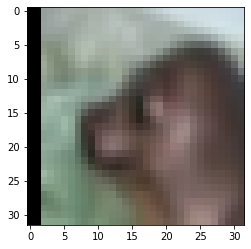

In [22]:
for img, lbl in train_loader:
    print(img.shape)
    print(classes[lbl[0]])
    plt.imshow(img[0].permute(1, 2, 0))
    break

In [23]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [24]:
num_epochs = 5
net.train()

for epoch in range(num_epochs):
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()

        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            net.eval()

            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader):

                test_outputs = net(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()

            print(f'Test acc: {test_running_right / test_running_total:.3f}')

        net.train()

print('Training is finished!')

Epoch [1/5]. Step [1/372]. Loss: 0.036. Acc: 0.016. Test acc: 0.013
Epoch [1/5]. Step [301/372]. Loss: 0.035. Acc: 0.021. Test acc: 0.028
Epoch [2/5]. Step [1/372]. Loss: 0.034. Acc: 0.039. Test acc: 0.033
Epoch [2/5]. Step [301/372]. Loss: 0.033. Acc: 0.032. Test acc: 0.042
Epoch [3/5]. Step [1/372]. Loss: 0.033. Acc: 0.055. Test acc: 0.045
Epoch [3/5]. Step [301/372]. Loss: 0.032. Acc: 0.049. Test acc: 0.072
Epoch [4/5]. Step [1/372]. Loss: 0.032. Acc: 0.047. Test acc: 0.074
Epoch [4/5]. Step [301/372]. Loss: 0.032. Acc: 0.062. Test acc: 0.080
Epoch [5/5]. Step [1/372]. Loss: 0.031. Acc: 0.062. Test acc: 0.084
Epoch [5/5]. Step [301/372]. Loss: 0.031. Acc: 0.073. Test acc: 0.095
Training is finished!


In [25]:
resnet18 = models.resnet18(pretrained=True)
resnet18 = resnet18.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [26]:
for param in list(resnet18.parameters())[:]:
    param.requires_grad = False

In [27]:
from torchsummary import summary

resnet18.fc = nn.Linear(512, 100)

summary(resnet18.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [28]:
train_actions = transforms.Compose([transforms.Resize(256),
                                    transforms.RandomCrop(224, padding=4),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
valid_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])


train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, train_actions)
valid_dataset = MyOwnCifar(valid_dataset, valid_transforms)

In [29]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=128,
                                           shuffle=False,
                                           num_workers=1)

In [30]:
params_to_update = []
for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)


optimizer = torch.optim.Adam(params_to_update, lr=0.001)
criterion = nn.CrossEntropyLoss()

In [31]:
num_epochs = 5
resnet18.train()

for epoch in range(num_epochs):
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()

        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            resnet18.eval()

            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader):

                test_outputs = resnet18(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()

            print(f'Test acc: {test_running_right / test_running_total:.3f}')

        resnet18.train()

print('Training is finished!')

Epoch [1/5]. Step [1/372]. Loss: 0.038. Acc: 0.016. Test acc: 0.012
Epoch [1/5]. Step [301/372]. Loss: 0.022. Acc: 0.355. Test acc: 0.478
Epoch [2/5]. Step [1/372]. Loss: 0.015. Acc: 0.531. Test acc: 0.502
Epoch [2/5]. Step [301/372]. Loss: 0.014. Acc: 0.520. Test acc: 0.536
Epoch [3/5]. Step [1/372]. Loss: 0.013. Acc: 0.492. Test acc: 0.541
Epoch [3/5]. Step [301/372]. Loss: 0.013. Acc: 0.553. Test acc: 0.554
Epoch [4/5]. Step [1/372]. Loss: 0.012. Acc: 0.594. Test acc: 0.560
Epoch [4/5]. Step [301/372]. Loss: 0.012. Acc: 0.567. Test acc: 0.565
Epoch [5/5]. Step [1/372]. Loss: 0.012. Acc: 0.562. Test acc: 0.566
Epoch [5/5]. Step [301/372]. Loss: 0.012. Acc: 0.580. Test acc: 0.571
Training is finished!
